## JWST Pipeline Validation Testing Notebook: NIRISS/SOSS Time Series Observation, pt. 2
**Instruments affected**: NIRISS

### Table of Contents
1. [Imports](#Imports_ID)

2. [Introduction](#intro)

3. [The `assign_wcs` step](#assign_wcs)

4. [The `extract_2d` step](#extract2d)

5. [The `flat_field` step](#flatfield)

### <a id=#Imports_ID>Imports</a>

Here are the lirbaries being imported here and why:

- `numpy` for numerical calculations.
- `matplotlib.pyplot` for plots.
- `astropy.io.fits` for importing fits files.
- `jwst.pipeline.calwebb_spec2` for using the CalWebb Spec 2 stage.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.io import fits
from jwst.pipeline import calwebb_spec2
from jwst import datamodels

Version of the pipeline we are testing:

In [3]:
import jwst
print(jwst.__version__)

0.16.1


## <a id='intro'> Introduction </a>

In this notebook we'll be testing that the Stage 2 of the CalWebb Spec pipeline works as intended as a whole. We'll stop after every step to quickly check that the results make sense. The whole set of steps ran by TSOs by this first Stage of the CalWebb Pipeline can be found [<a href="https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2">here</a>]. In what follows, we'll have one section associated to each step, calibrating the data sequentially and exploring the outputs accordingly.

## <a id='groupscale'> The `assign_wcs` step </a>

We first test and validate the `assign_wcs` step. This step simply associates a WCS object with the whole science exposure, which in turn allows to extract positions and wavelengths with a simple call. Let's add this to the rateint products:

In [4]:
calwebb_spec2.assign_wcs_step.AssignWcsStep.call('output/data_k2-141_superbiasstep_corrected_1_rampfitstep.fits', output_dir='output',save_results=True)

2020-07-30 00:12:39,299 - CRDS - ERROR -  Error determining best reference for 'pars-assignwcsstep'  =   Unknown reference type 'pars-assignwcsstep'
2020-07-30 00:12:39,301 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2020-07-30 00:12:39,587 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('output/data_k2-141_superbiasstep_corrected_1_rampfitstep.fits',).
2020-07-30 00:12:39,588 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2020-07-30 00:13:29,914 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs
2020-07-30 00:13:40,186 - stpipe.AssignWcsStep - INFO - Saved model in output/data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits
20

<CubeModel(308, 256, 2048) from data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits>

All right! Let's check that the WCS information is on the headers now:

In [7]:
hdul_wcs = fits.open('output/data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits')
exposure = datamodels.SpecModel('output/data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits')

In [8]:
column, row, order = 2047, 255, 2
ra, dec, wavelength = exposure.meta.wcs(column, row, order)
print(ra,dec,wavelength)

350.9165458333333 -1.189291666666667 0.0


Great --- it works. One sligthly confusing detail is that the documentation for this step suggests that you have to ingest five values, whereas apparently three suffice for NIRISS/SOSS at least. Given a column and a row in the detector level (and an order), this information returns the position and wavelength at that position. Let's create a map of wavelengths for order 1, 2 and 3 to test how this works in detail:

In [13]:
rows,columns = hdul_wcs['SCI'].data[0,:,:].shape
wavelength_maps = np.zeros([3,rows,columns])
for order in [1,2,3]:
    for row in range(rows):
        for column in range(columns):
            wavelength_maps[order-1,row,column] = exposure.meta.wcs(column, row, order)[-1]

All right --- let's plot those maps now:

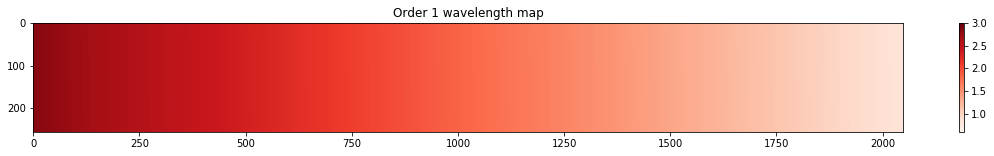

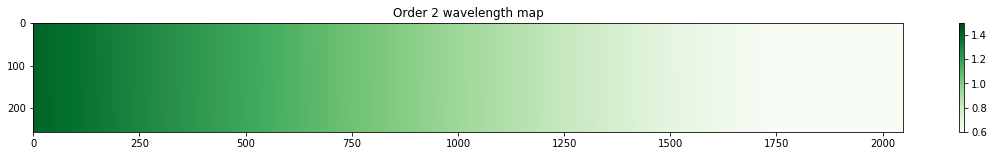

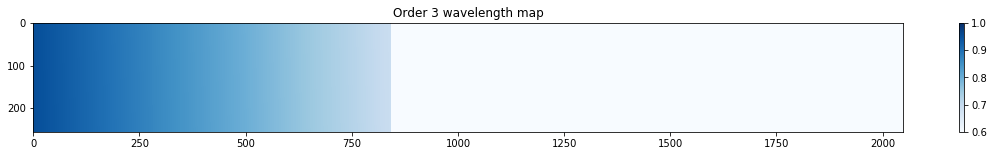

In [25]:
plt.figure(figsize=(20,2))
plt.title('Order 1 wavelength map')
im1 = plt.imshow(wavelength_maps[0,:,:])
im1.set_clim(0.6,3.0)
im1.set_cmap('Reds')
cb1 = plt.colorbar()

plt.figure(figsize=(20,2))
plt.title('Order 2 wavelength map')
im2 = plt.imshow(wavelength_maps[1,:,:])
im2.set_clim(0.6,1.5)
im2.set_cmap('Greens')
cb2 = plt.colorbar()

plt.figure(figsize=(20,2))
plt.title('Order 3 wavelength map')
im3 = plt.imshow(wavelength_maps[2,:,:])
im3.set_clim(0.6,1.0)
im3.set_cmap('Blues')
cb3 = plt.colorbar()


They look pretty good!

This step, by the way, should not do anything on the data itself, so we don't do any analyses in the data itself. <font color='green'>**We consider the step validated from the NIRISS/SOSS point of view.**</font>

## <a id='extract2d'> The `extract_2d` step </a>

We now move to the `extract_2d` step which extract 2D spectra from the images. In theory, this step is skipped by NIRISS/SOSS --- but let's go ahead and try running it using our AssignWCS products:

In [28]:
calwebb_spec2.extract_2d_step.Extract2dStep.call('output/data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits', output_dir='output',save_results=True)

2020-07-30 15:47:49,685 - CRDS - ERROR -  Error determining best reference for 'pars-extract2dstep'  =   Unknown reference type 'pars-extract2dstep'
2020-07-30 15:47:49,743 - stpipe.Extract2dStep - INFO - Extract2dStep instance created.
2020-07-30 15:47:51,875 - stpipe.Extract2dStep - INFO - Step Extract2dStep running with args ('output/data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits',).
2020-07-30 15:47:51,882 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'apply_wavecorr': True, 'extract_orders': None, 'extract_height': None, 'grism_objects': None, 'mmag_extract': 99.0}
2020-07-30 15:48:37,765 - stpipe.Extract2dStep - INFO - EXP_TYPE is NIS_SOSS
2020-07-30 15:48:37,788 - stpipe.Extract2

<CubeModel(308, 256, 2048) from data_k2-141_superbiasstep_corrected_1_extract2dstep.fits>

Indeed, it says "not supported" for `NIS_SOSS` --- let's see what the outputs of this look like:

In [30]:
hdul_e2d = fits.open('output/data_k2-141_superbiasstep_corrected_1_extract2dstep.fits')
print(hdul_wcs.info())
print(hdul_e2d.info())

Filename: output/data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     160   ()      
  1  SCI           1 ImageHDU        17   (2048, 256, 308)   float32   
  2  ERR           1 ImageHDU        11   (2048, 256, 308)   float32   
  3  DQ            1 ImageHDU        12   (2048, 256, 308)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (2048, 256, 308)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (2048, 256, 308)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [50440044B]   
None
Filename: output/data_k2-141_superbiasstep_corrected_1_extract2dstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   ()      
  1  SCI           1 ImageHDU        17   (2048, 256, 308)   float32   
  2  ERR           1 Imag

No real change in the data structure. Let's continue.

## <a id='flatfield'> The `flat_field` step </a>

This step applies the flat field correction to our NIRISS/SOSS data. Let's run our WCS products through this:

In [31]:
calwebb_spec2.flat_field_step.FlatFieldStep.call('output/data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits', output_dir='output',save_results=True)

2020-07-30 15:55:38,266 - CRDS - ERROR -  Error determining best reference for 'pars-flatfieldstep'  =   Unknown reference type 'pars-flatfieldstep'
2020-07-30 15:55:38,422 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2020-07-30 15:55:39,881 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args ('output/data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits',).
2020-07-30 15:55:39,884 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False}
2020-07-30 15:56:30,819 - stpipe.FlatFieldStep - WARNING - Keyword CDP_INTERNAL_FLAT does not correspond to an existing DQ mnemonic, so will be ignored
2020-07-30 15:57:03,655 - stpipe.FlatFieldStep - INFO - Extracting ma

<CubeModel(308, 256, 2048) from data_k2-141_superbiasstep_corrected_1_flatfieldstep.fits>

The step was run --- let's see the differences in the science products:

Filename: output/data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     160   ()      
  1  SCI           1 ImageHDU        17   (2048, 256, 308)   float32   
  2  ERR           1 ImageHDU        11   (2048, 256, 308)   float32   
  3  DQ            1 ImageHDU        12   (2048, 256, 308)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (2048, 256, 308)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (2048, 256, 308)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [50440044B]   
None


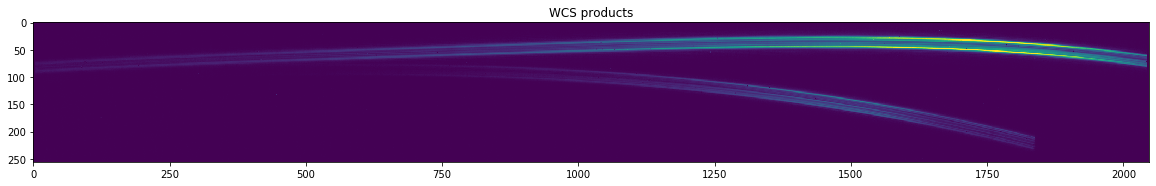

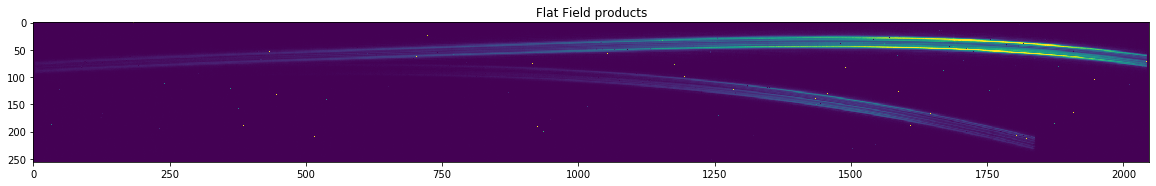

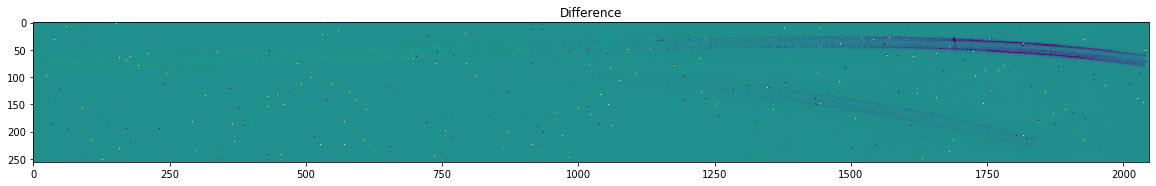

In [34]:
hdul_flat = fits.open('output/data_k2-141_superbiasstep_corrected_1_flatfieldstep.fits')
print(hdul_wcs.info())

plt.figure(figsize=(20,10))
plt.title('WCS products')
im = plt.imshow(hdul_wcs['SCI'].data[0,:,:])
im.set_clim(0,1000)

plt.figure(figsize=(20,10))
plt.title('Flat Field products')
im = plt.imshow(hdul_flat['SCI'].data[0,:,:])
im.set_clim(0,1000)

plt.figure(figsize=(20,10))
plt.title('Difference')
im = plt.imshow(hdul_wcs['SCI'].data[0,:,:] - hdul_flat['SCI'].data[0,:,:])
im.set_clim(-100,100)

All right! It seems flat fielding was indeed applied. Let's inspect one column to see how big the difference is. Let's say, column 1500 in the first integration:

(0.0, 0.1)

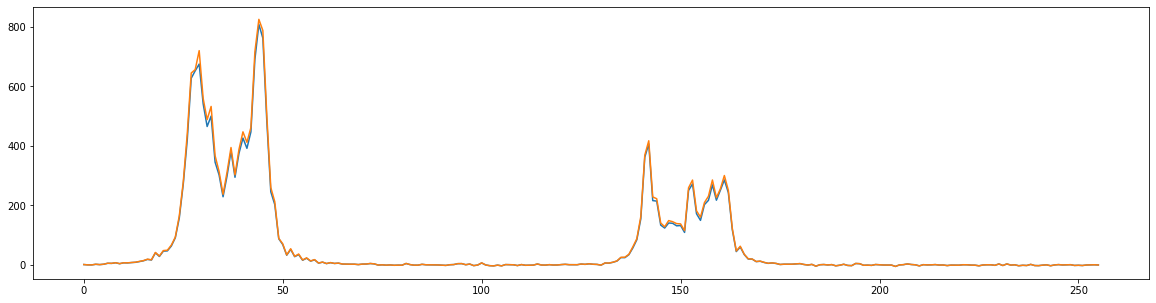

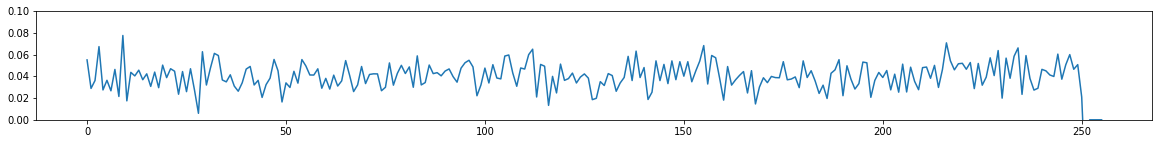

In [40]:
plt.figure(figsize=(20,5))
plt.plot(hdul_wcs['SCI'].data[0,:,1500])
plt.plot(hdul_flat['SCI'].data[0,:,1500])

plt.figure(figsize=(20,2))
plt.plot(1.-(hdul_wcs['SCI'].data[0,:,1500]/hdul_flat['SCI'].data[0,:,1500]))
plt.ylim([0.0,0.1])

All right, so differences are on the order of ~5% absolute flux, but vary at around ~2%. <font color='green'>**We consider the step validated from the NIRISS/SOSS point of view.**</font>

## <a id='srctype'> The `srctype` step </a>

This step applies populates the “SRCTYPE” keyword --- for TSOs, this should default to “POINT”. Let's test this:

In [43]:
calwebb_spec2.srctype_step.SourceTypeStep.call('output/data_k2-141_superbiasstep_corrected_1_flatfieldstep.fits', output_dir='output',save_results=True)

2020-07-31 00:06:46,962 - CRDS - ERROR -  Error determining best reference for 'pars-sourcetypestep'  =   Unknown reference type 'pars-sourcetypestep'
2020-07-31 00:06:46,966 - stpipe.SourceTypeStep - INFO - SourceTypeStep instance created.
2020-07-31 00:06:47,632 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep running with args ('output/data_k2-141_superbiasstep_corrected_1_flatfieldstep.fits',).
2020-07-31 00:06:47,634 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-07-31 00:06:50,059 - stpipe.SourceTypeStep - INFO - Input EXP_TYPE is NIS_SOSS
2020-07-31 00:06:50,060 - stpipe.SourceTypeStep - INFO - Input SRCTYAPT = None
2020-07-31 00:06:50,061 - stpipe.SourceTypeStep - WARNING - SRCTYAPT keyword not fo

<CubeModel(308, 256, 2048) from data_k2-141_superbiasstep_corrected_1_sourcetypestep.fits>

Indeed, the pipeline states that because this is a TSO exposure, `SRCTYPE` is set to `POINT`. Let's check this indeed is the case:

In [45]:
hdul_srctype = fits.open('output/data_k2-141_superbiasstep_corrected_1_sourcetypestep.fits')
print('SRCTYPE was:', hdul_flat['SCI'].header['SRCTYPE'])
print('SRCTYPE is:', hdul_srctype['SCI'].header['SRCTYPE'])

SRCTYPE was: POINT
SRCTYPE is: POINT


Perfect! <font color='green'>**We consider the step validated from the NIRISS/SOSS point of view.**</font>

## <a id='photom'> The `photom` step </a>

This step performs flux calibrations to our data, converting units from countrates to flux densities and/or surface brightness. Let's apply that to our `sourcetype` outputs:

In [47]:
calwebb_spec2.photom_step.PhotomStep.call('output/data_k2-141_superbiasstep_corrected_1_sourcetypestep.fits', output_dir='output',save_results=True)

2020-07-31 00:15:42,809 - CRDS - ERROR -  Error determining best reference for 'pars-photomstep'  =   Unknown reference type 'pars-photomstep'
2020-07-31 00:15:42,812 - stpipe.PhotomStep - INFO - PhotomStep instance created.
2020-07-31 00:15:43,157 - stpipe.PhotomStep - INFO - Step PhotomStep running with args ('output/data_k2-141_superbiasstep_corrected_1_sourcetypestep.fits',).
2020-07-31 00:15:43,161 - stpipe.PhotomStep - INFO - Step PhotomStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-07-31 00:15:47,181 - stpipe.PhotomStep - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_niriss_photom_0037.fits
2020-07-31 00:15:47,183 - stpipe.PhotomStep - INFO - Using area reference file: N/A
2020-07-31 00:15:50,565 - stpipe.PhotomStep - INFO

<CubeModel(308, 256, 2048) from data_k2-141_superbiasstep_corrected_1_photomstep.fits>

All right! It seems it worked. Let's compare the values:

In [49]:
hdul_photom = fits.open('output/data_k2-141_superbiasstep_corrected_1_photomstep.fits')

2020-07-31 00:26:30,515 - stpipe - WARNING - /Users/nespinoza/anaconda3/envs/exoctk-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]



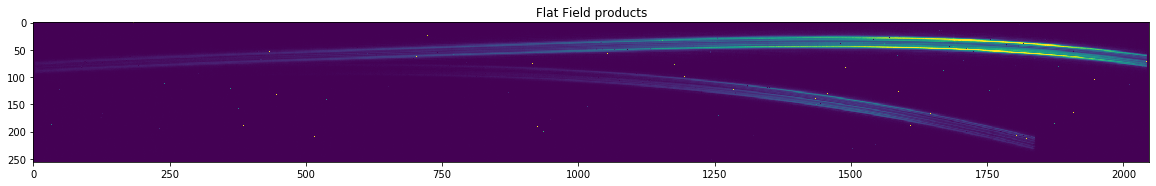

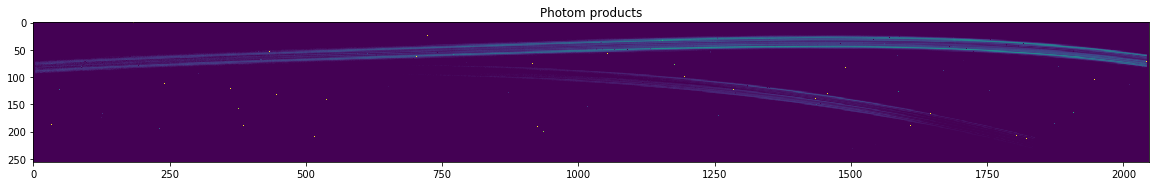

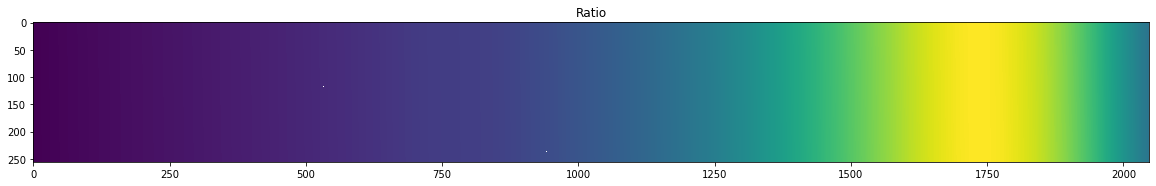

In [72]:
plt.figure(figsize=(20,10))
plt.title('Flat Field products')
im = plt.imshow(hdul_flat['SCI'].data[0,:,:])
im.set_clim(0,1000)

plt.figure(figsize=(20,10))
plt.title('Photom products')
im = plt.imshow(hdul_photom['SCI'].data[0,:,:])
im.set_clim(1e-8,3e-7)

plt.figure(figsize=(20,10))
plt.title('Ratio')
im = plt.imshow(hdul_flat['SCI'].data[0,:,:]/hdul_photom['SCI'].data[0,:,:])
#im.set_clim(-100,100)

Text(0.5, 0, 'Row number')

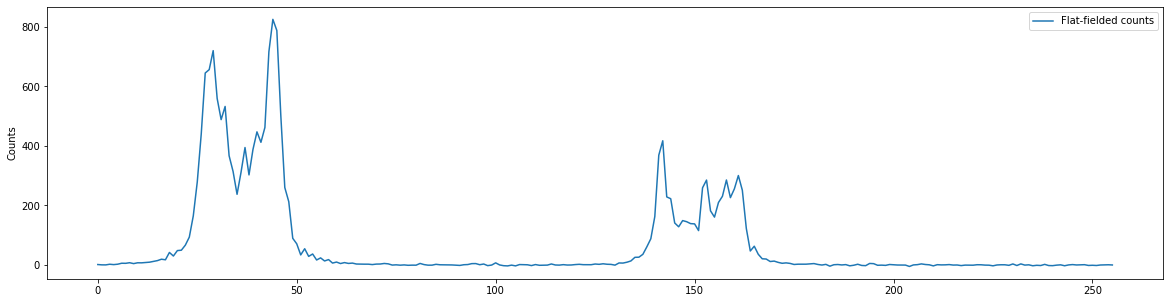

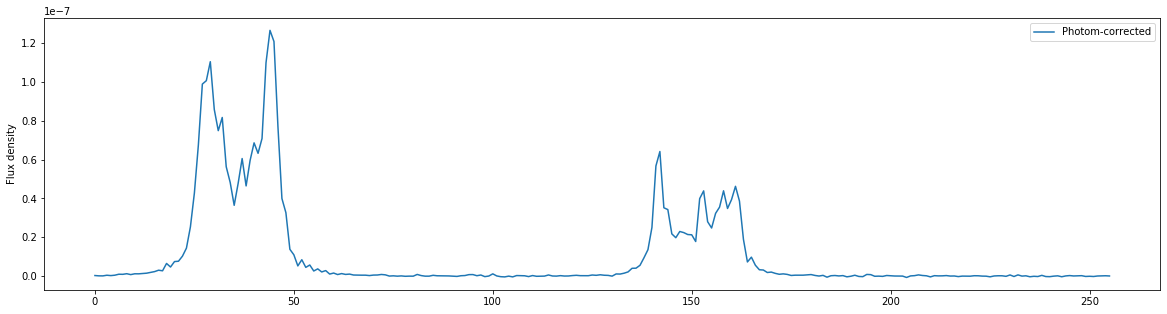

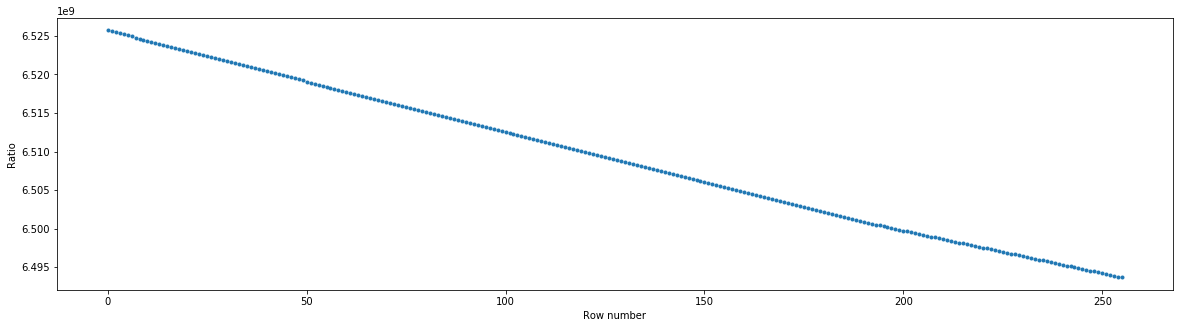

In [73]:
plt.figure(figsize=(20,5))
plt.plot(hdul_flat['SCI'].data[0,:,1500],label='Flat-fielded counts')
plt.legend()
plt.ylabel('Counts')

plt.figure(figsize=(20,5))
plt.plot(hdul_photom['SCI'].data[0,:,1500],label='Photom-corrected')
plt.legend()
plt.ylabel('Flux density')

plt.figure(figsize=(20,5))
plt.ylabel('Ratio')
plt.plot(hdul_flat['SCI'].data[0,:,1500]/hdul_photom['SCI'].data[0,:,1500],'.')
plt.xlabel('Row number')